In [1]:
import pandas as pd
import torch
import os
from sklearn.model_selection import train_test_split
from  torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import torchvision.models as models
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from Code.CustomResnet18 import CustomResnet18
from Code.OnnxModel import OnnxModel
import matplotlib.pyplot as plt

# EDA

data: https://www.kaggle.com/competitions/facial-keypoints-detection/overview

In [2]:
main_df = pd.read_csv(os.path.join('data', 'training.csv'))

In [3]:
main_df.shape

(7049, 31)

In [4]:
main_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
main_df.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [6]:
# as an option we can just drop nans (for baseline)
main_df.dropna(inplace=True) 

In [7]:
main_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [8]:
main_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


# Train test split

In [9]:
seed = 33
train_df, valtest_df = train_test_split(main_df, test_size=0.3, random_state=seed)
val_df, test_df = train_test_split(valtest_df, test_size=1/3, random_state=seed)

In [10]:
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

# Deal with nans

In [11]:
feat_names = list(train_df.columns)[:-1]
feat_names

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'nose_tip_x',
 'nose_tip_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [12]:
scaler = StandardScaler()
scaler.fit(train_df[feat_names])
imputer = KNNImputer(n_neighbors=5)
# imputer = IterativeImputer(max_iter=30, random_state=seed)
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(scaler.transform(train_df[feat_names]))

,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [13]:
def replace_nans(df: pd.DataFrame):
    scaled_data = scaler.transform(df[feat_names])
    nans_imputed = imputer.transform(scaled_data)
    data_scale_restored = scaler.inverse_transform(nans_imputed)
    new_df = pd.DataFrame(data_scale_restored, columns=feat_names)
    new_df['Image']=df['Image']
    return new_df

train_df = replace_nans(train_df)
val_df = replace_nans(val_df)
test_df = replace_nans(test_df)

# Make target, data features

In [14]:
def make_target(df: pd.DataFrame) -> None:
    df['target_arr'] = df[feat_names].apply(lambda row: torch.tensor(row.values, dtype=torch.float32).reshape(-1, 2), axis=1)

make_target(train_df)
make_target(val_df)
make_target(test_df)

In [15]:
def make_img_preprocessed(df: pd.DataFrame) -> None:
    img_shape = (1, 96, 96)
    df['Image_preprocessed'] = df['Image'].map(lambda img: torch.tensor(list(map(lambda x: int(x), img.split())), dtype=torch.float32).reshape(*img_shape)/255.0)
    df.drop(columns=['Image'], inplace=True)

make_img_preprocessed(train_df)
make_img_preprocessed(val_df)
make_img_preprocessed(test_df)

# Create datasets for train, test, val

In [16]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, pd_df: pd.DataFrame):
        self.pd_df = pd_df

    def __len__(self):
        return self.pd_df.shape[0]

    def __getitem__(self, idx):
        return self.pd_df.iloc[idx]['Image_preprocessed'], self.pd_df.iloc[idx]['target_arr']

In [17]:
train_ds = FaceLandmarksDataset(train_df)
val_ds = FaceLandmarksDataset(val_df)
test_ds = FaceLandmarksDataset(test_df)

In [18]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Init model

In [19]:
import torch
from torchvision.models import resnet18
import torchvision.models as models


class CustomResnet18(torch.nn.Module):
    def __init__(self, out_dim: int):
        super().__init__()
        self.model = resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        in_features = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features, out_dim)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        for param in self.model.parameters():
            param.requires_grad = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.model(x)
        sh = y.shape
        outp = y.reshape(sh[0], sh[1]//2, 2)
        return outp
        

In [20]:
target_sh = train_df['target_arr'][0].shape
out_dim = target_sh[0]*target_sh[1]
model = CustomResnet18(out_dim=out_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model = model.to(device)

# Train model

In [21]:
class RMSEmLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.msloss = torch.nn.MSELoss()

    def forward(self, inp, target):
        loss = torch.sqrt(self.msloss(inp, target))
        return loss

# loss = RMSELoss() 
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Decay LR by a factor of 0.5 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [22]:
from copy import deepcopy


def train_model(model, loss, optimizer, scheduler, num_epochs, 
                train_dataloader, val_dataloader, device: str):
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    best_loss = float('inf')
    best_model = deepcopy(model)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()

            epoch_loss = running_loss / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
            else:
                val_loss[epoch] = epoch_loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model = deepcopy(model)
                    print('new best model was found!')

            print('{} Loss: {:.4f}'.format(phase, epoch_loss), flush=True)

    return train_loss, val_loss, best_model


def validate_model(model, loss_f, dataloader, device: str):
    total_loss = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            loss_value = loss_f(preds, labels)
            total_loss += loss_value.item()
    mean_loss = total_loss / len(dataloader)
    print('Loss: {:.4f}'.format(mean_loss), flush=True)

In [23]:
num_epochs = 30
train_loss, val_loss, model = train_model(model, loss, optimizer, scheduler, num_epochs, train_dl, val_dl, device)

Epoch 0/29:


D:\Python\Environments\python312_main_venv\Lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.00it/s]

train Loss: 1493.6982



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.13it/s]

new best model was found!
val Loss: 444.3710
Epoch 1/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.42it/s]

train Loss: 259.2813



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.50it/s]

new best model was found!
val Loss: 65.8369
Epoch 2/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.21it/s]

train Loss: 29.1498



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.93it/s]

new best model was found!
val Loss: 11.4754
Epoch 3/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.17it/s]

train Loss: 9.3532



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.87it/s]

new best model was found!
val Loss: 10.8973
Epoch 4/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.22it/s]

train Loss: 8.5522



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.13it/s]

new best model was found!
val Loss: 9.9088
Epoch 5/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.27it/s]

train Loss: 8.4253



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.00it/s]

val Loss: 12.0031
Epoch 6/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 8.1270



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.55it/s]

val Loss: 10.7401
Epoch 7/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 7.5399



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.24it/s]

new best model was found!
val Loss: 8.5060
Epoch 8/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]


train Loss: 7.1218


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.94it/s]

val Loss: 14.4818
Epoch 9/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]


train Loss: 6.8092


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.93it/s]

new best model was found!
val Loss: 8.1089
Epoch 10/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 6.5182



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.87it/s]

val Loss: 8.7218
Epoch 11/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 6.0905



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.99it/s]

new best model was found!
val Loss: 7.2812
Epoch 12/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.25it/s]

train Loss: 5.8461



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.55it/s]

val Loss: 8.9433
Epoch 13/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.27it/s]

train Loss: 5.6030



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.83it/s]

new best model was found!
val Loss: 6.4157
Epoch 14/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.27it/s]

train Loss: 5.2829



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.01it/s]

new best model was found!
val Loss: 6.2654
Epoch 15/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.24it/s]

train Loss: 5.2271



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.72it/s]

new best model was found!
val Loss: 5.7354
Epoch 16/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 5.0075



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.06it/s]

val Loss: 5.9167
Epoch 17/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 4.7701



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.84it/s]

new best model was found!
val Loss: 5.3853
Epoch 18/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.25it/s]

train Loss: 4.5456



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.89it/s]

new best model was found!
val Loss: 5.2422
Epoch 19/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]


train Loss: 4.3064


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.08it/s]

new best model was found!
val Loss: 4.7650
Epoch 20/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 4.1679



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.96it/s]

val Loss: 5.0409
Epoch 21/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]


train Loss: 4.0733


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.06it/s]

new best model was found!
val Loss: 4.7607
Epoch 22/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.25it/s]

train Loss: 4.0800



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.76it/s]

new best model was found!
val Loss: 4.4436
Epoch 23/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.24it/s]

train Loss: 3.8767



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.64it/s]

val Loss: 4.6601
Epoch 24/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.24it/s]

train Loss: 3.7747



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.19it/s]

new best model was found!
val Loss: 4.1838
Epoch 25/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.24it/s]

train Loss: 3.7391



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.68it/s]

val Loss: 4.4470
Epoch 26/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.25it/s]

train Loss: 3.6370



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.20it/s]

val Loss: 4.3186
Epoch 27/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.25it/s]

train Loss: 3.6002



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.78it/s]

new best model was found!
val Loss: 4.0336
Epoch 28/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]

train Loss: 3.5449



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.24it/s]

new best model was found!
val Loss: 3.9696
Epoch 29/29:



100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.26it/s]


train Loss: 3.5162


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.73it/s]

new best model was found!
val Loss: 3.9091


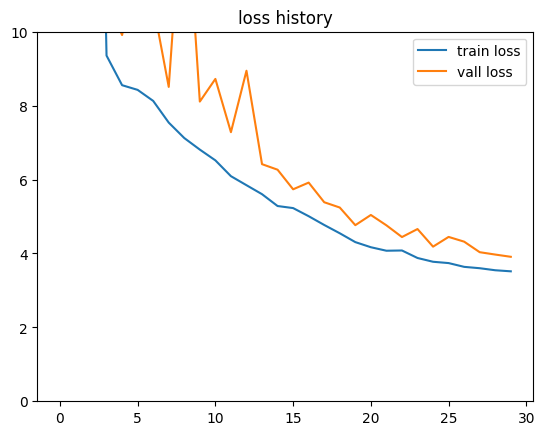

In [24]:
epochs = list(range(num_epochs))
plt.title('loss history')
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='vall loss')
plt.legend()
plt.ylim(ymin=0, ymax=10)
plt.show()

# Analyze model's metrics

In [25]:
validate_model(model, loss, val_dl, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.39it/s]

Loss: 3.9091


In [26]:
validate_model(model, loss, test_dl, device)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 22.09it/s]

Loss: 3.3780


# Save model

In [2]:
onnx_model_path = os.path.join('SavedModels', 'resnet18_fl.onnx')
torch_model_path = os.path.join('SavedModels', 'resnet18_fl.pt')

In [27]:
model.to('cpu')

torch.save(model, torch_model_path)

In [28]:
torch.onnx.export(
    model,
    train_ds[0][0].unsqueeze(0),
    onnx_model_path,
    export_params=True,  # Export trained parameter weights
    opset_version=16,    # ONNX operator set version
    do_constant_folding=True, # Optimize constants in the graph
    input_names=['input'],   # Name for the input node
    output_names=['output'], # Name for the output node
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # Allow dynamic batch size
)

# Test saved models

In [4]:
torch_model = torch.load(torch_model_path, weights_only=False)
torch_model.eval()

In [6]:
tens_x = torch.rand(10,1,96,96)

In [32]:
torch_outp = torch_model(tens_x)

In [7]:
# Load the ONNX model
onnx_model = OnnxModel(onnx_model_path)
x_np = tens_x.numpy()
onnx_outp = onnx_model(x_np)

In [34]:
np.max(np.abs(torch_outp.detach().numpy()-onnx_outp))

np.float32(4.5776367e-05)

In [35]:
%%timeit
onnx_model(x_np)

68.9 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%%timeit
torch_model(tens_x)

192 ms ± 68.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
torch_model(val_ds[96][0].unsqueeze(0))

tensor([[[66.7444, 38.4515],
         [30.3242, 40.4067],
         [59.5039, 40.0571],
         [74.5570, 38.9482],
         [37.5531, 41.2593],
         [22.0417, 41.7596],
         [55.2963, 32.3791],
         [80.3648, 30.8335],
         [39.6848, 33.3091],
         [15.0585, 34.9345],
         [49.2929, 62.1632],
         [66.9284, 79.8056],
         [34.8404, 81.9195],
         [50.7016, 79.2453],
         [51.0272, 86.1512]]], grad_fn=<ViewBackward0>)

In [38]:
onnx_model(val_ds[96][0].unsqueeze(0).numpy())

array([[[66.744446 , 38.45145  ],
        [30.324223 , 40.4067   ],
        [59.503914 , 40.05709  ],
        [74.557014 , 38.94817  ],
        [37.553135 , 41.259335 ],
        [22.041746 , 41.75959  ],
        [55.29627  , 32.379135 ],
        [80.36479  , 30.83353  ],
        [39.68477  , 33.30905  ],
        [15.0584955, 34.934452 ],
        [49.292953 , 62.163235 ],
        [66.92841  , 79.80562  ],
        [34.84041  , 81.91943  ],
        [50.70163  , 79.24531  ],
        [51.027237 , 86.15124  ]]], dtype=float32)

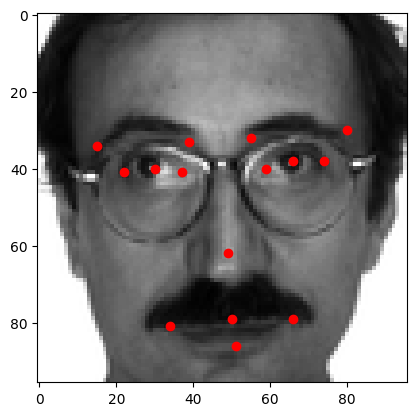

In [39]:
idx = 96
points = onnx_model(val_ds[idx][0].unsqueeze(0).numpy())[0]
plt.imshow(val_ds[idx][0][0], cmap='gray')
for point in points:
    plt.plot(int(point[0]), int(point[1]), 'ro')
    #break
plt.show()

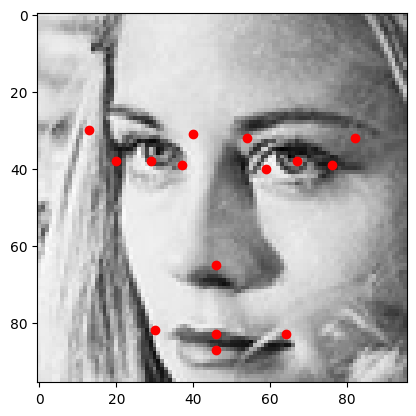

In [62]:
idx = 97
points = onnx_model(test_ds[idx][0].unsqueeze(0).numpy())[0]
plt.imshow(test_ds[idx][0][0], cmap='gray')
for point in points:
    plt.plot(int(point[0]), int(point[1]), 'ro')
    #break
plt.show()